reference:
https://www.nltk.org/api/nltk.parse.html
reference:
https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt

from wordcloud import WordCloud


import nltk  
import seaborn as sns

from collections import Counter
import sys
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.feature_selection import SelectKBest
from warnings import filterwarnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
filterwarnings('ignore')
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [2]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

In [3]:
# np.set_printoptions(threshold=sys.maxsize)

In [4]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 1. Data Cleaning

### 1.1 Load data

In [5]:
# load the meta data from the CSV file 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

#show 10 lines of the new dataframe
print (df.shape)
df.head(10)

(45774, 5)
(34809, 5)


,title,doi,abstract,publish_time,authors
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen
5,The infant airway microbiome in health and dis...,10.1101/012070,the nasopharynx (np) is a reservoir for microb...,2014-12-02,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...
6,Using heterogeneity in the population structur...,10.1101/017178,"abstractin 2013, u.s. swine producers were con...",2015-03-27,Eamon B. O’Dea; Harry Snelson; Shweta Bansal
7,"Big city, small world: Density, contact rates,...",10.1101/018481,macroscopic descriptions of populations common...,2015-04-27,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...
8,MERS-CoV recombination: implications about the...,10.1101/020834,recombination is a process that unlinks neighb...,2015-06-12,Gytis Dudas; Andrew Rambaut
9,On the causes of evolutionary transition:trans...,10.1101/027722,a pattern in which nucleotide transitions are ...,2015-09-28,Arlin Stoltzfus; Ryan W. Norris


In [6]:
df_1=pd.read_csv('metadata.csv')
df_1.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


In [7]:
df_1 = df_1.drop_duplicates(subset='sha', keep="first")
df_1.shape

(31745, 17)

In [8]:
df_1=df_1.dropna(subset=["title",'abstract'])

### 1.2.1 Function: remove pure number

In [9]:
def clean(string):
    term =re.sub( r"[^\s\w]+",' ',string) # Remove non alphanumeric characters except space
    term = re.sub(r"(\s\d+)", ' ', term)  # remove pure numbers
   
    return term

### 1.2.2 Function: remove stopwords

In [10]:

def remove_stopword(data):

#     data=data.apply(lambda x: [word for word in x if word not in stopwords.words('english')])   
    words=data.split()
    words_rmStop = [word for word in words if word not in stopWords]

    return words_rmStop

### 1.3 All characters in the text are in lowercase

datframe desicription: df: only include title, abstract, time, and authers. 

df_1 add papaer id.

df_covid add all the body text connent.

In [11]:
df['abstract_clean']=df['abstract'].str.lower()
df['abstract_clean']=df['abstract_clean'].apply(remove_stopword)
df['abstract_clean']=df['abstract_clean'].apply(lambda x:' '.join(x))
df['abstract_clean']=df['abstract_clean'].apply(clean)

In [12]:
df_1['abstract_clean']=df_1['abstract'].str.lower()
df_1['abstract_clean']=df_1['abstract_clean'].apply(remove_stopword)
df_1['abstract_clean']=df_1['abstract_clean'].apply(lambda x:' '.join(x))
df_1['abstract_clean']=df_1['abstract_clean'].apply(clean)

### 1.4 Accessing full-text of articles
#### Get the whole article from local documents

In [13]:
all_json = glob.glob(f'{"CORD-19-research-challenge"}/**/*.json', recursive=True)
len(all_json)

33375

In [14]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
#     def __repr__(self):
#         return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [15]:
dict_ = {'paper_id': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
        
    dict_['paper_id'].append(content.paper_id)
    
    dict_['body_text'].append(content.body_text)
            
#     # get metadata information
#     meta_data = df.loc[df['sha'] == content.paper_id]
    
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'body_text'])
df_covid.head()

Processing index: 0 of 33375
Processing index: 3337 of 33375
Processing index: 6674 of 33375
Processing index: 10011 of 33375
Processing index: 13348 of 33375
Processing index: 16685 of 33375
Processing index: 20022 of 33375
Processing index: 23359 of 33375
Processing index: 26696 of 33375
Processing index: 30033 of 33375
Processing index: 33370 of 33375


,paper_id,body_text
0,86a998617c077f4fe2ab26214995a3548fbc0fc5,While most CoVs cause the common cold in human...
1,948aaeb2e0be11ad90562bf10d462531a1f00eac,Clinically relevant respiratory viral signatur...
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,The evolutionary history of humans is characte...
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,"Sixty years ago, civil aviation was an infant ..."
4,eb5c7f3ff921ad6469b79cc8a3c122648204ece4,Acute infections of the gastrointestinal tract...


### 1.5 Clean the whole body text & remove the duplicate data, and drop NaN data

In [16]:
df_covid.drop_duplicates(subset='paper_id', keep="first").shape

(33375, 2)

In [17]:
df_covid=df_covid.dropna(subset=['body_text'])

In [18]:
df_covid['body_text_clean']=df_covid['body_text'].str.lower()
df_covid['body_text_clean']=df_covid['body_text_clean'].apply(remove_stopword)
df_covid['body_text_clean']=df_covid['body_text_clean'].apply(lambda x:' '.join(x))
df_covid['body_text_clean']=df_covid['body_text_clean'].apply(clean)

In [19]:
df_covid=df_covid.rename(columns={"paper_id": "sha"})

### 1.6 Merge the title, public time, abstract and body text

In [20]:
df_merged=pd.merge(df_1, df_covid, on='sha')

In [21]:
df_merged.shape

(26416, 20)

# 2. Data Visualization and Exploratory Data Analysis


### 2.1 Display time distribution 

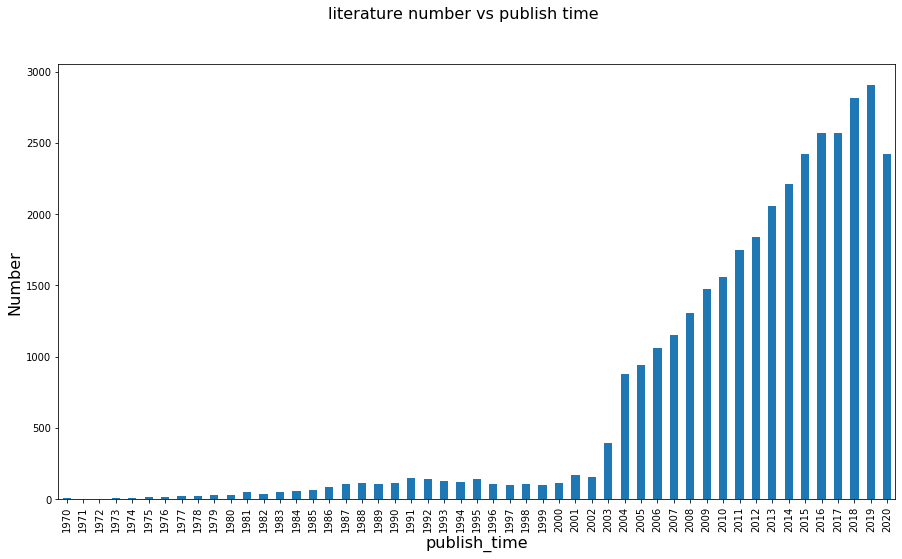

In [23]:
df['publish_time']=df['publish_time'].astype("datetime64")
fig=plt.figure(figsize=(15,8))
fig.suptitle('literature number vs publish time',fontsize=16)
plt.xlabel('publish_time', fontsize=16)
plt.ylabel('Number', fontsize=16)
df.groupby(df["publish_time"].dt.year).count()['publish_time'].plot(kind="bar")

#### Comment: Coronavirus is a RNA virus. From 2004, Sars is most recent fatal virus. In this assignment, I'd like to know how to prevent the covid-19 and find the potential therapy for people, and medical treatment.  From the bar plot above, the literature increase rapidly after 2003. Because the SarS kills thousand of people. Therefore, to find more useful information, we can choose to use data after 2003. I like to use the most recent literature to look insight. The very old literature has very few value to refer. In the next step, I will choose the filter the data, and only keep the data after 2003.

### 2.2 Filter data, keep data after 2003 year

In [369]:
df_merged['title_clean']=df_merged['title'].str.lower()
df_merged['title_clean']=df_merged['title_clean'].apply(remove_stopword)
df_merged['title_clean']=df_merged['title_clean'].apply(lambda x:' '.join(x))
df_merged['title_clean']=df_merged['title_clean'].apply(clean)


df_merged["time_clean"]=df_merged['publish_time'].astype("datetime64")
df_merged=df_merged[df_merged["time_clean"].dt.year>=2003]

In [25]:
df_merged.shape

(24309, 22)

### 2.3 Display keyword from article title
#### If only look the keyword, we can find the keyword is infection, virus and protein, which make senses because the coronavirus is much easily infectious to other people. Therefore, we can infer that these articles are talking about infection of virus more than other things. Therefore, in this assignment, we can get some insight about the transmission about the COVID-19 

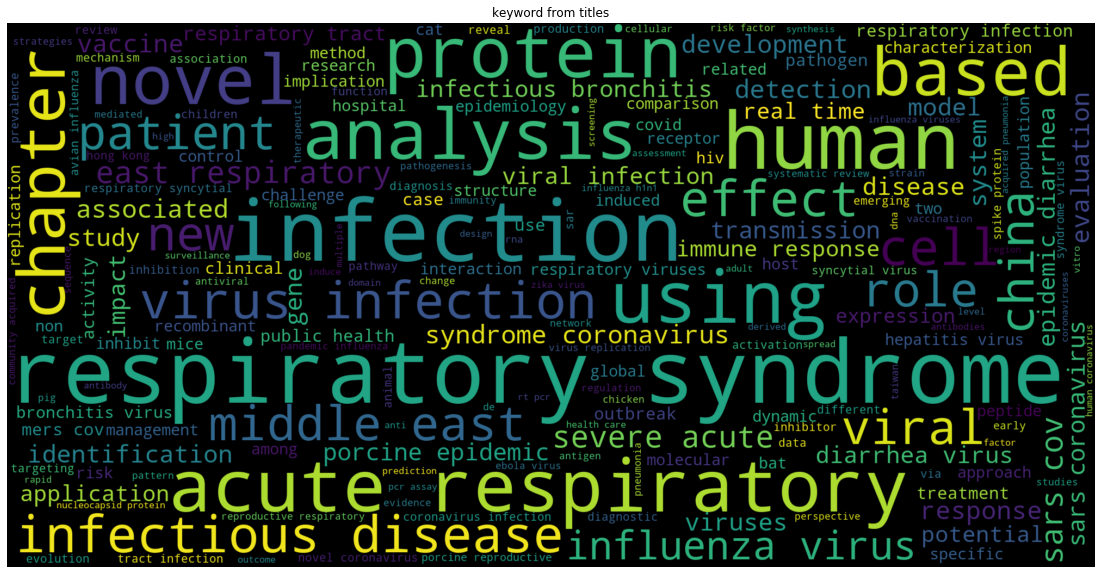

In [370]:
word_0=df_merged['title_clean']

word_0=" ".join(word_0)


wordcloud = WordCloud(width = 2000, height = 1000, max_words=200,repeat=False).generate(word_0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('keyword from titles')
plt.axis("off")
plt.show()

### 2.4 Display keywords from article's abstracts 

#### keywords from abstract make senses. we can find the keywords: method, treatment, infection, result. Besides, these article includes more talk about the SARS and MERS. The covid-19, MERS and SARS are same kind of virus. Therefore, in these articles, we can analyze the other coronavirus to get the some features of COVID-19, and also know something common with coronavirus. 


In [27]:
df_merged['abstract_clean']=df_merged['abstract'].str.lower()
df_merged['abstract_clean']=df_merged['abstract_clean'].apply(remove_stopword)
df_merged['abstract_clean']=df_merged['abstract_clean'].apply(lambda x:' '.join(x))
df_merged['abstract_clean']=df_merged['abstract_clean'].apply(clean)




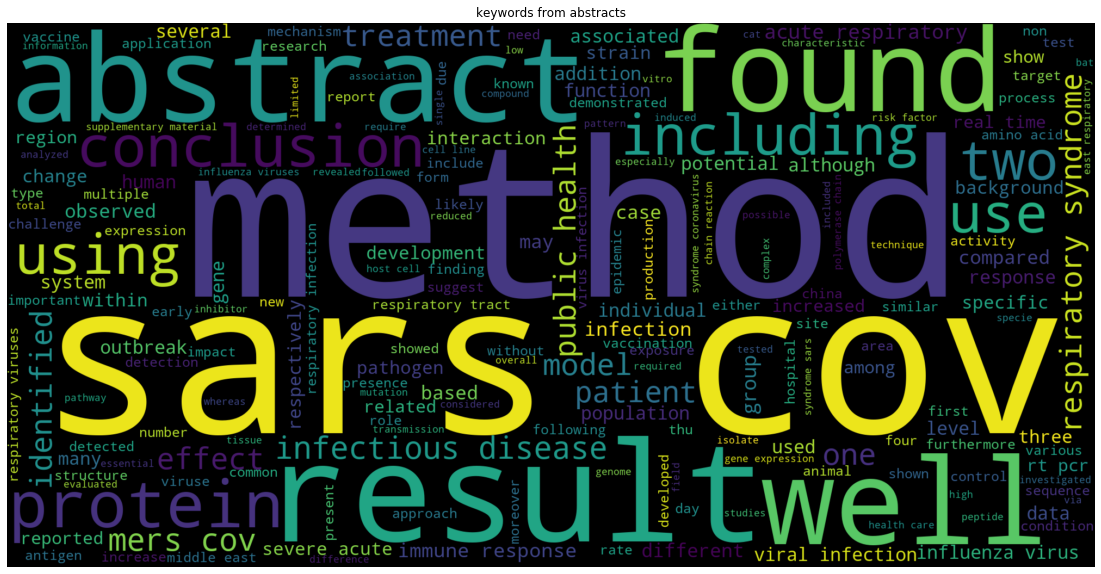

In [371]:
word_0=df_merged['abstract_clean']

word_0=" ".join(word_0)


wordcloud = WordCloud(width = 2000, height = 1000, max_words=200,repeat=False).generate(word_0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('keywords from abstracts')
plt.axis("off")
plt.show()

### 2.4 Key Noun Phrase from abstract

In [29]:
from nltk.tag import PerceptronTagger
tagger = PerceptronTagger()
pos_tag = tagger.tag
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [35]:
# Noun Phrase Extraction Support Functions

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopWords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [36]:

def top_k_phrases(k, df, string):
    reviews = df[string].values      
    counter = Counter()
    for index, review in enumerate (reviews):
        print(index)
        # review = ' '.join(x for x in review.split() if x not in stop)
        counter.update(word for word in flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]) if word not in stopWords)
        topk = counter.most_common(k)
    return topk



In [37]:
top50_phrase = top_k_phrases(50, df_merged,"abstract_clean")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070


3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718


5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358


6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000


8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644


10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
1023

11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
1160

12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
1297

14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
1434

15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
1570

16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
1707

18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
1843

19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
1980

21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
2117

22375
22376
22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
2254

23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
2390

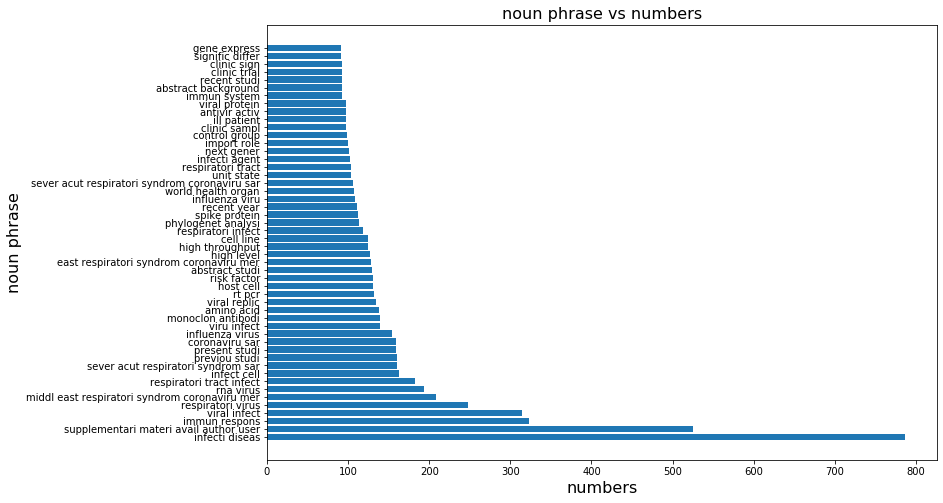

In [372]:
top50_phrase_array=np.array(top50_phrase)
fig=plt.figure(figsize=(12,8))
plt.title('noun phrase vs numbers',fontsize=16)
plt.xlabel('numbers', fontsize=16)
plt.ylabel('noun phrase', fontsize=16)
plt.barh(top50_phrase_array[:,0],top50_phrase_array[:,1].astype(float),align='center')
plt.gca()


#### we parse natural language biomedical literature data, and try to get adj+noun combination. From noun phase we can find more useful information from these articles. We can see which top is the most popular topic in these articles. First, the infectous disease; second, the immunity response to coronavirus. Then, we also can see the respiratory virus, rna virus, infect cell and previous studi. Therefore, these noun phrases can help us better to know what is included in these articles. 

#### In this assignment, I want to find more information about transimission method and easy way to self-treat. Because, for the government and doctors, to prevent COVID-19 is to help the whole society. 

# 3. Model selection and fitting to data

### 3.1 Generate the TF-IDF for the abstracts

In [358]:
def generate_tf_idf(dataFrame,feature_column,top):

    
    tfidf_vector = TfidfVectorizer(stop_words='english',use_idf=False, norm="l1",max_features=top,strip_accents='unicode')
    X = tfidf_vector.fit_transform(dataFrame[feature_column]).toarray()

    #df_t=tfidf_vector.fit_transform(df_sentiment['text_ready'])
    featureNames=tfidf_vector.get_feature_names()

    rawDF=pd.DataFrame(X,columns=featureNames)
    return rawDF


def generate_most_freq(dataFrame,feature_column,top):

    vectorizer = CountVectorizer(stop_words='english',max_features=top,strip_accents='unicode')
    X = vectorizer.fit_transform(dataFrame[feature_column]).toarray()

    #df_t=tfidf_vector.fit_transform(df_sentiment['text_ready'])
    featureNames=vectorizer.get_feature_names()

    rawDF=pd.DataFrame(X,columns=featureNames)

    return rawDF

method=’ward’ uses the Ward variance minimization algorithm

### 3.2 Hierarchical Clustering the articles
#### in this step, we use tfidf to get the top 500 words in the abstracts. Then, we can see how many clusters we have. Then based on the number of the clusters, we can seperate the articles and generate the topics of each clusters. 
#### Here, we need one more steps, I compared the tfidf and word frequency to see the different results of clustering. Within TDIFD, the clustering results looks more equally distributed. Within word frequency, the result doesn't make senses, because too many articles belong to one clusters. Therefore, here I would use tfidf, and the clustering results of tfidf
#### from the results, I believe these articles has 4 clusters from the graph of dengrogram. In other words, there are 4 topics of these articles. 

In [321]:
df_text_freq= generate_most_freq(df_merged,'abstract_clean',500)

In [285]:
Y_1= linkage(df_text_freq, method='ward')

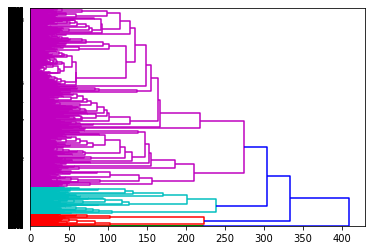

In [286]:
z_1=dendrogram(Y_1, orientation='right')

In [359]:
df_text_tfidf=generate_tf_idf(df_merged,'abstract_clean',500)

In [293]:
Y_2= linkage(df_text_tfidf, method='ward')


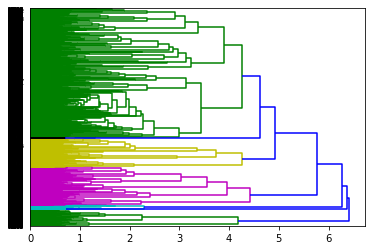

In [294]:
z_2=dendrogram(Y_2, orientation='right')

### 3.3 K-mean clustering the articles
#### From the results, when I use for loop to tune the best number of clusters. I find the 4 is the best choice. The results match the results of hierarchical clustering. 

In [367]:
# ax=plt.subplot(4,2)
# for i in range(2,10):
#     model = KMeans(n_clusters=i)
#     clusters = model.fit_predict(df_text_tfidf)
#     ax.hist(clusters)


In [368]:
model = KMeans(n_clusters=4)
clusters = model.fit_predict(df_text_tfidf)

In [320]:
df_text_tfidf['cluster']=clusters

(array([  838.,     0.,     0.,  4719.,     0.,     0., 12837.,     0.,
            0.,  5915.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

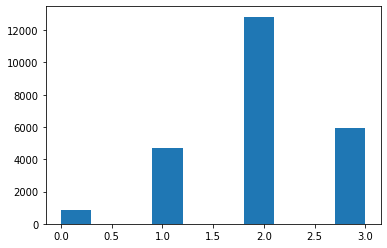

In [318]:
plt.hist(clusters)

### 3.4 Finding 1: Find the topic in each clusters of articles 
#### the results present below: Topic 1:  cells virus infection protein viral cell expression proteins immune host;    Topic 2:  virus viruses pcr samples viral detection respiratory study results using;   Topic 3:  health disease data diseases influenza infectious public study control results;    Topic 4:  patients respiratory infection cov sars study virus clinical children infections

### 3.4.1 Discuss and interpret the findings of these models
#### in the part 3, I use unsupervised clustering to cluster the articles, and then i can get the topics of each cluster. This can get doctor and government to sort these articles, and it is very convenient to look what includes in these articles, and where they should get their requiring information.
#### in summary, Topic 1 talks about how the virus infects host cell. Topic 2 talks about how people detect the virus, and related to the respiratory study. Topic 3 talks about how to control these disease, and protect public health. Topic 4 talks about study about coronavirus including sars and patients study and chlidren infections. 

In [356]:
n_topics=4
def get_keys(topic_matrix):

    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):

    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
#         print(temp_vector_sum)
#         print(type(temp_vector_sum))
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [341]:


vectorizer = CountVectorizer(stop_words='english',max_features=300,strip_accents='unicode')

df_text_freq_matrix = vectorizer.fit_transform(df_merged["abstract_clean"])
X = vectorizer.fit_transform(df_merged["abstract_clean"]).toarray()

#df_t=tfidf_vector.fit_transform(df_sentiment['text_ready'])
featureNames=tfidf_vector.get_feature_names()

df_text_tfidf=pd.DataFrame(X,columns=featureNames)

In [324]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=4, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(df_text_freq)

In [327]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [357]:
top_n_words_lda = get_top_n_words(10, lda_keys, df_text_freq_matrix,vectorizer )

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  cells virus infection protein viral cell expression proteins immune host
Topic 2:  virus viruses pcr samples viral detection respiratory study results using
Topic 3:  health disease data diseases influenza infectious public study control results
Topic 4:  patients respiratory infection cov sars study virus clinical children infections


### 3.5 Finding 2: Find the relation between each treatment
### 3.5.1 Discuss and interpret the findings of these models
#### From the dendrogram, we can find the deep breathing and sleep is within a cluster. Ibuprofen, relievers and medication is within a cluster. Relaxation and physical activity is within a cluster. Drink water and fliud intake is within a cluster. Therefore, we can infer that there are four main treatment includes physical activity, drink water, take medication and sleep. 

In [40]:
treatment_list=['relievers',"ibuprofen",'acetaminophen','medication','fluid intake','sleep','walk',\
           'exercises','meditation','stretching','deep breathing','physical activity',\
            'drink water','relaxation',"medicines",'humidifier','warm']

In [42]:
tr_count = dict((tr,0) for tr in treatment_list)
for tr in tr_count:
    for text in df_merged['body_text_clean']:
        if str(tr) in text:
            tr_count[tr] += 1

In [43]:
tr_count

{'relievers': 12,
 'ibuprofen': 102,
 'acetaminophen': 112,
 'medication': 1956,
 'fluid intake': 30,
 'sleep': 591,
 'walk': 1400,
 'exercises': 372,
 'meditation': 19,
 'stretching': 177,
 'deep breathing': 20,
 'physical activity': 191,
 'drink water': 20,
 'relaxation': 388,
 'medicines': 893,
 'humidifier': 52,
 'warm': 1495}

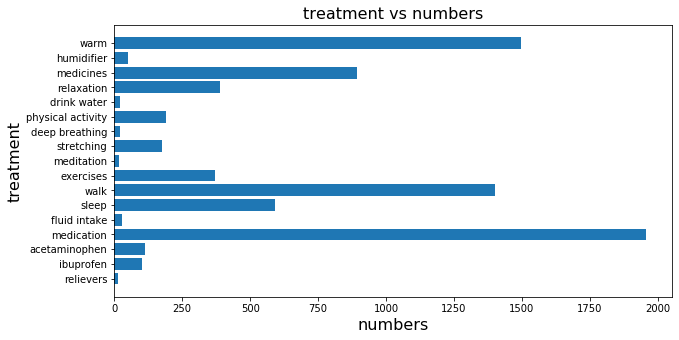

In [44]:
fig=plt.figure(figsize=(10,5))
plt.title('treatment vs numbers',fontsize=16)
plt.xlabel('numbers', fontsize=16)
plt.ylabel('treatment', fontsize=16)
plt.barh(list(tr_count.keys()),list(tr_count.values()),align='center')
plt.gca()

In [45]:
array_tr=[]
for tr in tr_count:
    for text in df_merged['body_text_clean']:
        if str(tr) in text:
             array_tr.append(10)
        else:
             array_tr.append(0)

In [47]:
array_tr=np.array(array_tr)
array_tr=array_tr.reshape((int(len(array_tr)/len(treatment_list)),len(treatment_list)))
df_tr=pd.DataFrame(array_tr,columns=treatment_list)

In [74]:
df_tr.shape

(24309, 17)

In [114]:
sel = VarianceThreshold(threshold=(22))
filter_array=sel.fit_transform(df_tr.T)

In [115]:
filter_array.shape

(17, 52)

In [128]:
Y_2= linkage(filter_array, method='ward')

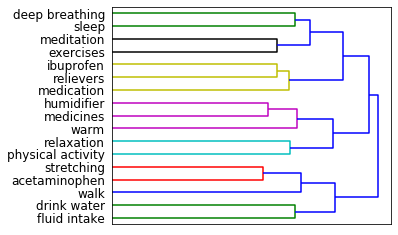

In [129]:
fig, ax1 = plt.subplots(1,1, figsize=(5, 4))
ax1.set_xticks([])
z_2=dendrogram(Y_2, orientation='right')
labels = df_tr.columns[z_2['leaves']]
ax1.set_yticklabels(labels)
plt.show()

### 3.6 Finding 3: Find the transmission method
### 3.6.1 Discuss and interpret the findings of these models
#### From the dendrogram, we can find there are two main clusters: non-air intermedium transmission and air transmission. Air transmission, community transmission,  contact transmission, and food transmission has very closed relationship. It makes sense because people infect others through air. It also shows community transmission relies on the aerosol intermedium. Besides, animal and water can be another very important transmission method.

In [200]:
transmission_list=['community transmission','contact tracing','contact transmission','aerosol transmission','air transmission','water transmission','food transmission','animal transmission']


In [201]:
tr_count = dict((tr,0) for tr in transmission_list)
for tr in tr_count:
    for text in df_merged['body_text_clean']:
        if str(tr) in text:
            tr_count[tr] += 1

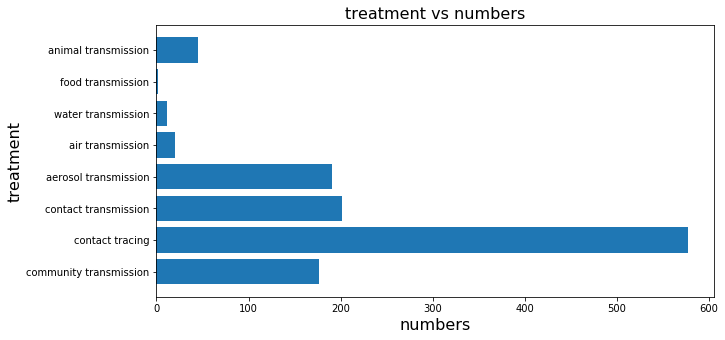

In [202]:
fig=plt.figure(figsize=(10,5))
plt.title('treatment vs numbers',fontsize=16)
plt.xlabel('numbers', fontsize=16)
plt.ylabel('treatment', fontsize=16)
plt.barh(list(tr_count.keys()),list(tr_count.values()),align='center')
plt.gca()

In [203]:
array_tr=[]
for tr in tr_count:
    for text in df_merged['body_text_clean']:
        if str(tr) in text:
             array_tr.append(10)
        else:
             array_tr.append(0)

In [204]:
array_tr=np.array(array_tr)
array_tr=array_tr.reshape((int(len(array_tr)/len(transmission_list)),len(transmission_list)))
df_tr=pd.DataFrame(array_tr,columns=transmission_list)

In [223]:
sel = VarianceThreshold(threshold=(20))
filter_array=sel.fit_transform(df_tr.T)

In [224]:
filter_array.shape

(8, 14)

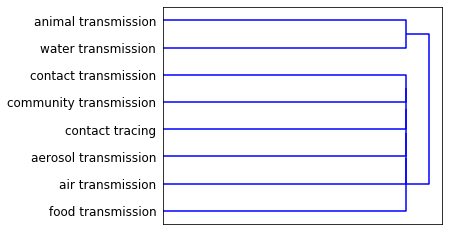

In [225]:
Y_2= linkage(filter_array, method='single')
fig, ax1 = plt.subplots(1,1, figsize=(5, 4))
ax1.set_xticks([])
z_2=dendrogram(Y_2, orientation='right')
labels = df_tr.columns[z_2['leaves']]
ax1.set_yticklabels(labels)
plt.show()

# 4. Deriving insights about policy and guidance to tackle the outbreak based on model findings

### 4.1 How scientists, doctors, nurses, healthcare professionals, industry and governments can best use the insights from your data science model to assist in the fight against the COVID-19 pandemic?

#### 4.1.1 From 3.4 findinds, we know there are four topics obtained from 3.5 findinds. Topic 1 talks about how the virus infects host cell. Topic 2 talks about how people detect the virus, and related to the respiratory study. Topic 3 talks about how to control these disease, and protect public health. Topic 4 talks about study about coronavirus including sars and patients study and chlidren infections. healthcare professionals can use this classificaiton to find their required documents very quickly.  Here, topic 3 is very useful for the government, because articles in topic 3 gives more research on how to control the spread, and how to protect public health

#### 4.1.2 From 3.5 findings, we know there are about four treatment methods. We know currently there are not enough place in hospital to accept infectious people. Very light symptom patients need to self-treatment. Therefore, patients need to drink more water, keep enough sleep, keep warm, relaxation and do some entertainment when staying home is very helpful to recover. Therefore, I suggestion the healthcare professionals and the government can publish a guide for people who stay home and need self treatment, which also can release the public healthcare pressure.

#### 4.1.3 From 3.6 findings, we know the main transmission way is through the air. Therefore, the community need to desease the contact of people. Government should encourage people stay home, and avoid the public gathering. When a place find a person infected by COVID-19, the whole place should be blocked to avoid virus spread. Besides, the water transmission is very dangerous. Government should try the best to keep the water supply is safe. 



### Proposed policies or action items
#### From 4.1, we can conclude some actions to avoid the virus spread. First of all, the government has take action to close the public places, which can avoid the air transmission between human. Second, government should encourage people wear masks. Because lots of people are asymptomatic carriers. Third, the shopping mall is encouraged to supply their goods by the shop assistant. Because people touch the goods in shopping mall may increase the cross infection.  

#### Policy:  1.government should require people stay home and work from home. 2. Fine the people who appear in public park, and party with friends. 3. Force people to keep distance with others more than 2 meters.